In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("brijbhushannanda1979/bigmart-sales-data")

# print("Path to dataset files:", path)

In [2]:
big_mart_data = pd.read_csv('big_mart_sales.csv')
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
big_mart_data.shape

(8523, 12)

In [6]:
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
big_mart_data['Outlet_Size'].value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [8]:
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
mode_of_outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
print(mode_of_outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [10]:
#fill the missing values for 'Outlet_Size' column depending on 'Outlet_Type' column
def fill_missing_values(row):
    if pd.isnull(row['Outlet_Size']):
        return mode_of_outlet_size[row['Outlet_Type']][0]
    else:
        return row['Outlet_Size']
big_mart_data['Outlet_Size'] = big_mart_data.apply(fill_missing_values, axis=1)
big_mart_data.isnull().sum()


C:\Users\adelz\AppData\Local\Temp\ipykernel_10564\2857256153.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return mode_of_outlet_size[row['Outlet_Type']][0]


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [11]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


C:\Users\adelz\AppData\Local\Temp\ipykernel_10564\2890395825.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Weight'])


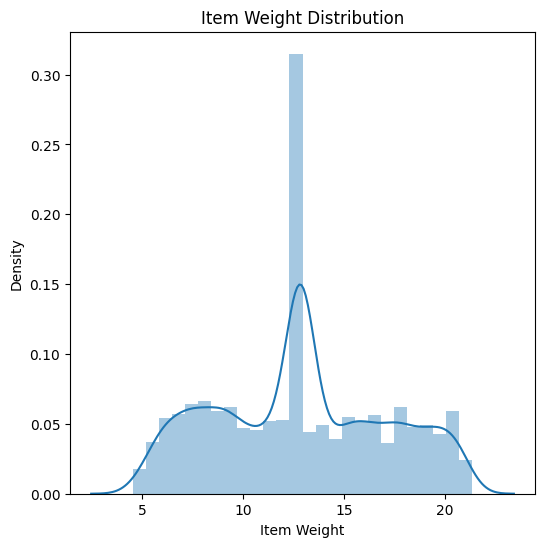

In [12]:
#item weight distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'])
plt.title('Item Weight Distribution')
plt.xlabel('Item Weight')
plt.show()

C:\Users\adelz\AppData\Local\Temp\ipykernel_10564\4204664552.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Visibility'])


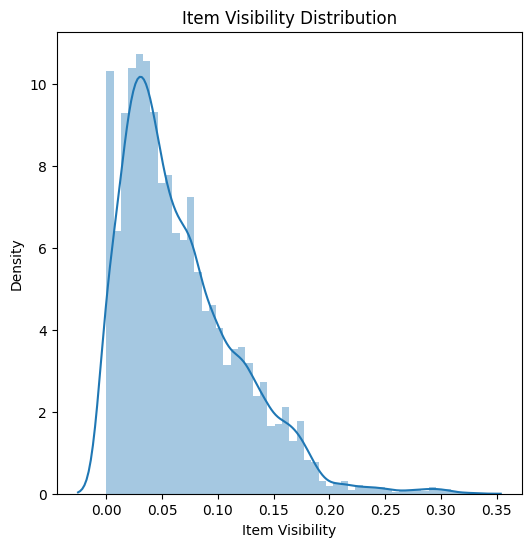

In [13]:
#itemVisibility content distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.title('Item Visibility Distribution')
plt.xlabel('Item Visibility')
plt.show()

C:\Users\adelz\AppData\Local\Temp\ipykernel_10564\3281590909.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_MRP'])


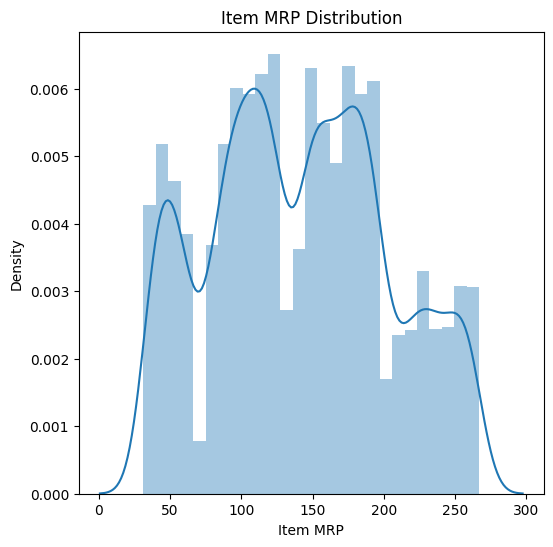

In [14]:
#item mrp content distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.title('Item MRP Distribution')
plt.xlabel('Item MRP')  
plt.show()

C:\Users\adelz\AppData\Local\Temp\ipykernel_10564\2521523939.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Outlet_Sales'])


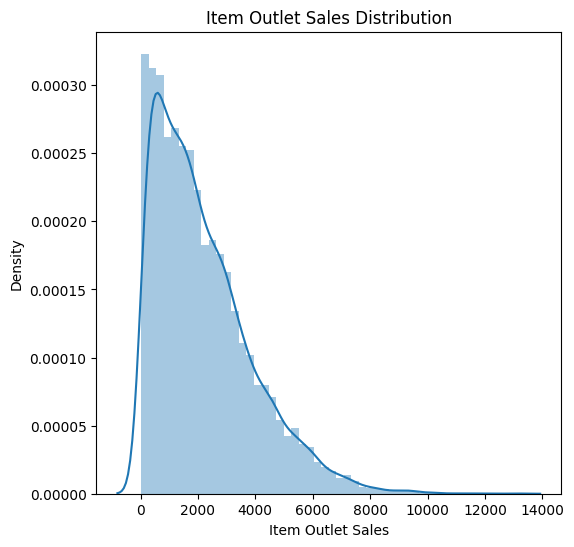

In [15]:
#item outlet sales distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.title('Item Outlet Sales Distribution')
plt.xlabel('Item Outlet Sales')
plt.show()


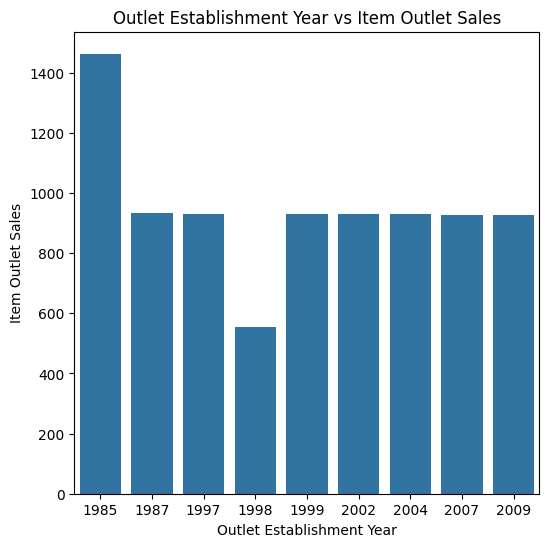

In [16]:
#outlet_establishment_year vs Item outlet sales
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.title('Outlet Establishment Year vs Item Outlet Sales')
plt.xlabel('Outlet Establishment Year') 
plt.ylabel('Item Outlet Sales')
plt.show()

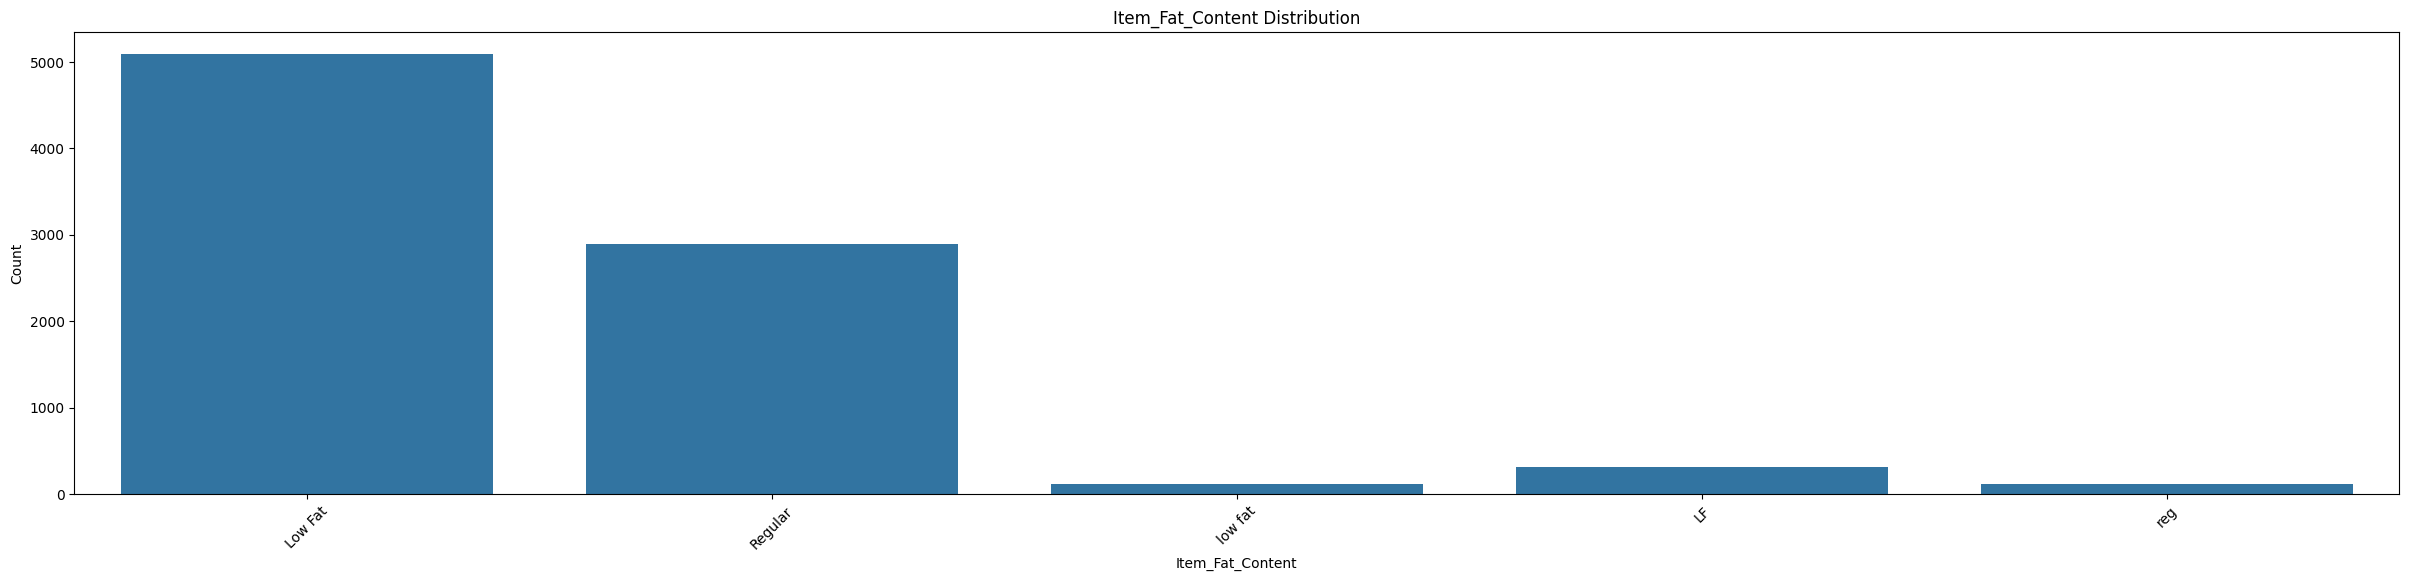

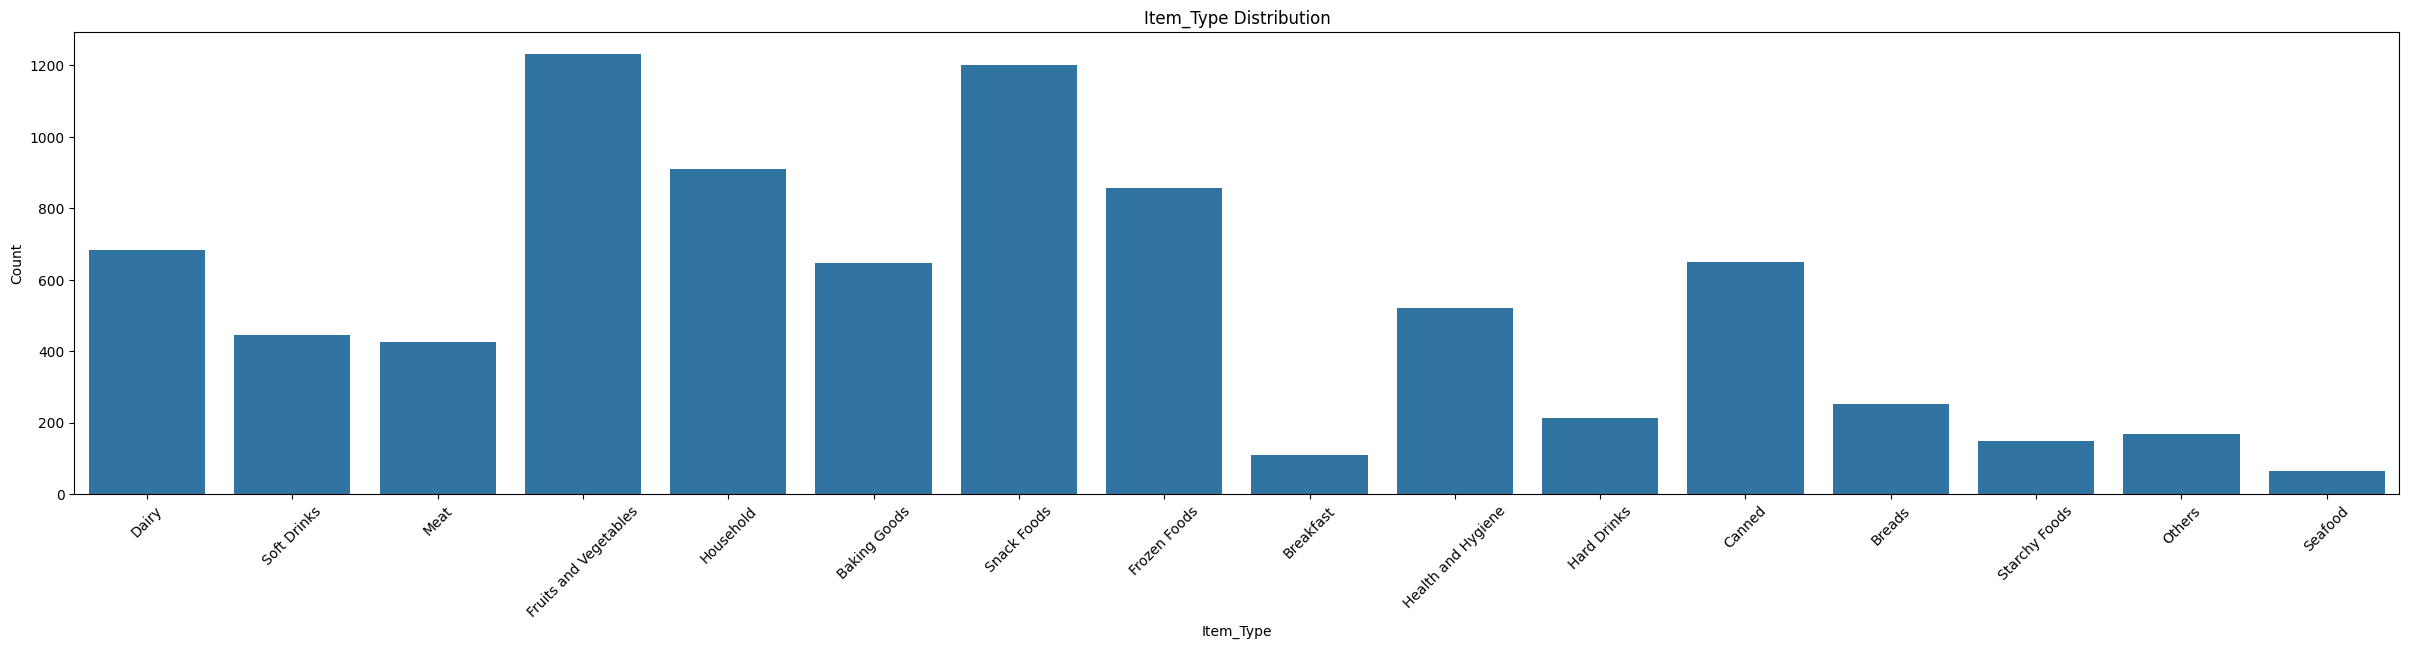

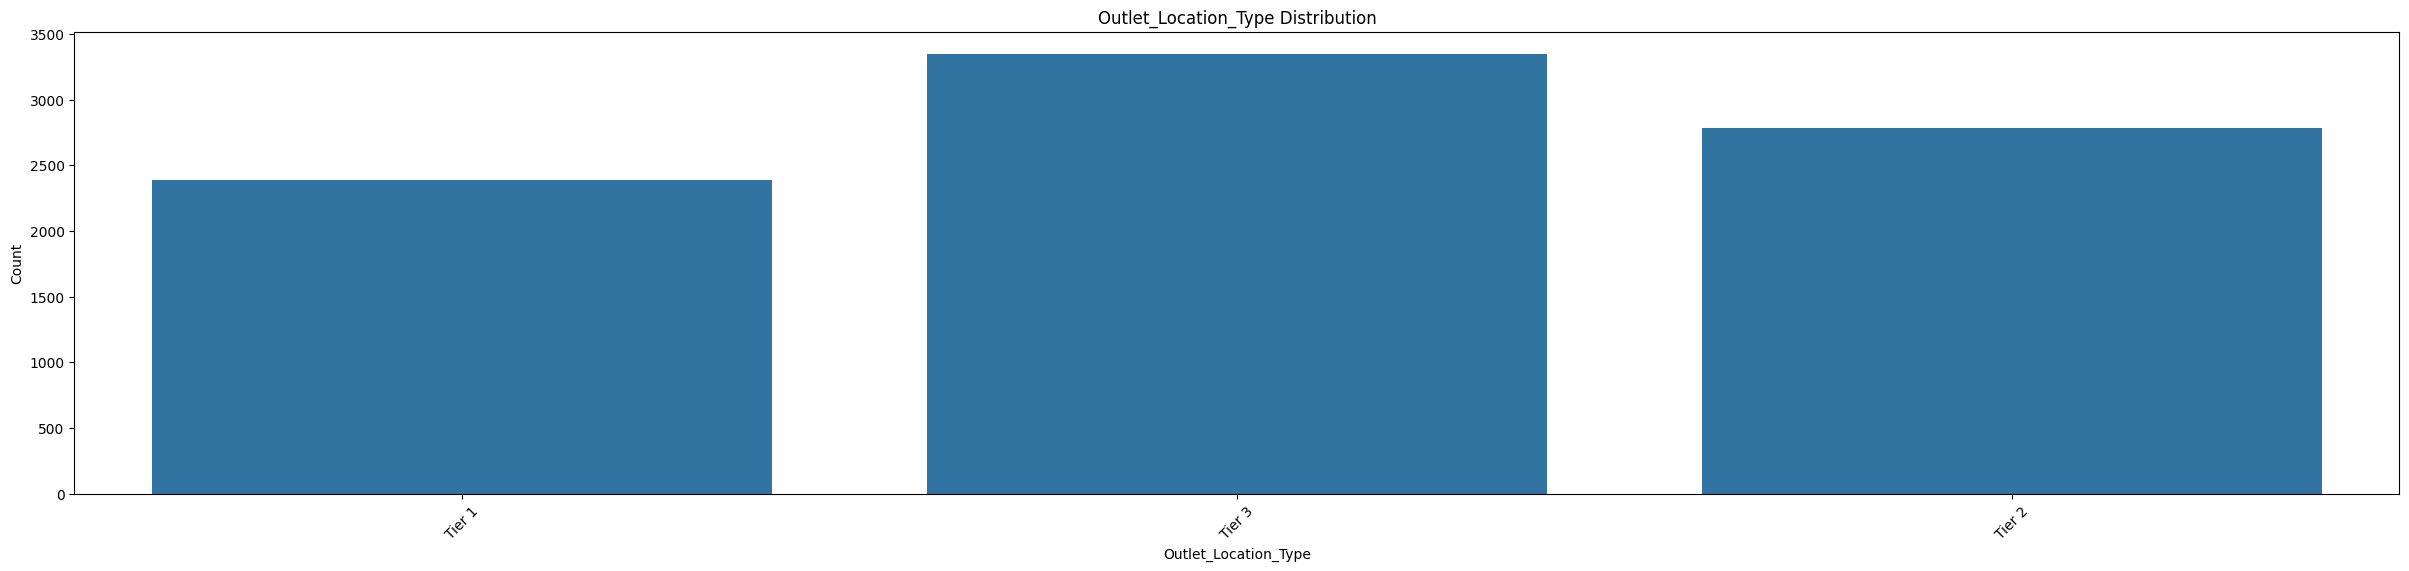

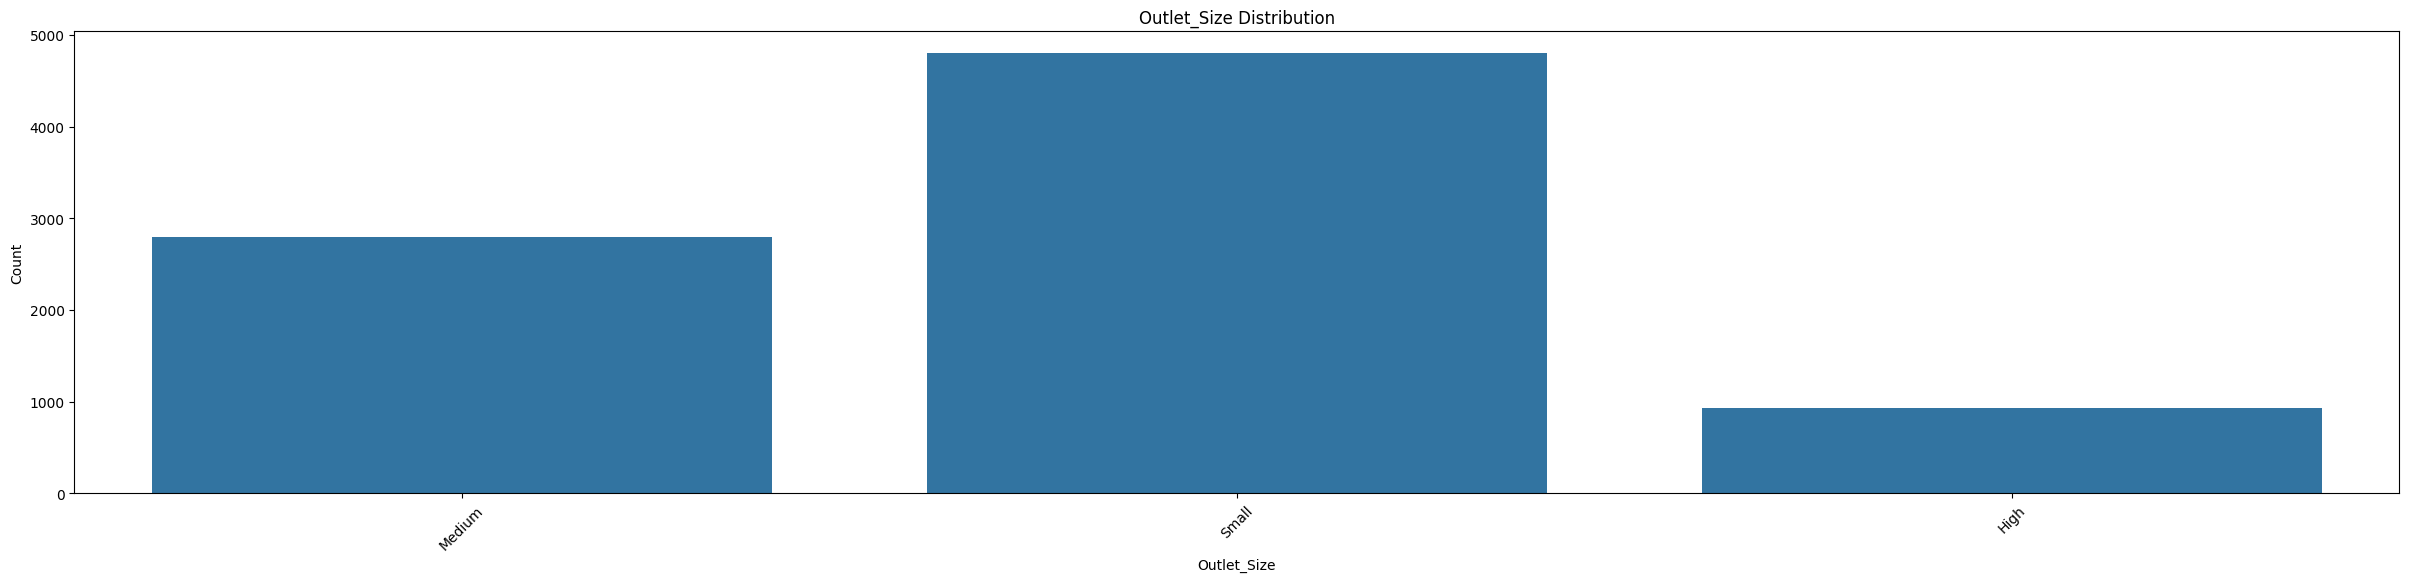

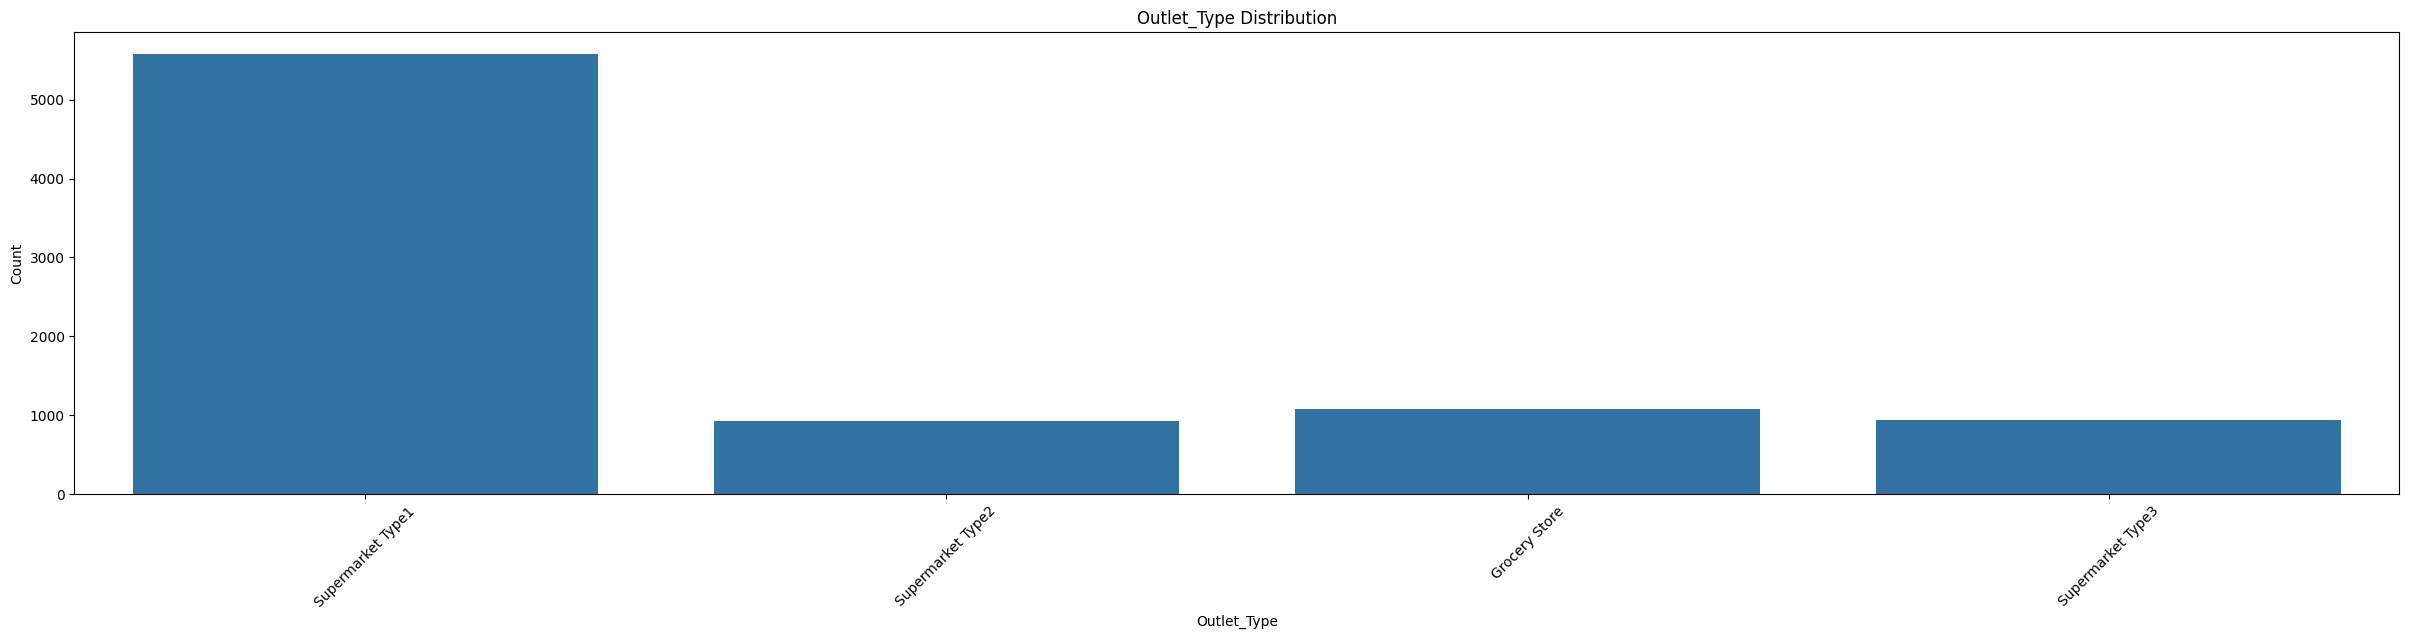

In [17]:
#  now plot for categorical features
categorical_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type']
for col in categorical_columns:
    plt.figure(figsize=(30,6))
    sns.countplot(x=col, data=big_mart_data)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
Encoded_columns = ['Outlet_Identifier','Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type']

for col in Encoded_columns:
    # Check if the column has any non-null categorical values
    if big_mart_data[col].notna().sum() > 0:
        # Fit encoder on non-null values only
        non_null_mask = big_mart_data[col].notna()
        non_null_values = big_mart_data.loc[non_null_mask, col]
        
        # Fit and transform only non-null values
        encoded_values = encoder.fit_transform(non_null_values)
        
        # Assign encoded values back only to non-null positions
        big_mart_data.loc[non_null_mask, col] = encoded_values

big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,1,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,DRC01,5.92,2,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,FDN15,17.50,1,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,FDX07,19.20,2,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,NCD19,8.93,1,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [19]:
big_mart_data=big_mart_data.drop(columns=['Item_Identifier'], axis=1)
big_mart_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,1,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,5.92,2,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,17.50,1,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,19.20,2,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,8.93,1,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [20]:
#standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP','Outlet_Establishment_Year']
big_mart_data[numerical_columns] = scaler.fit_transform(big_mart_data[numerical_columns])
big_mart_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,-0.841872,1,-0.970732,4,1.747454,9,0.139541,1,0,1,3735.1380
1,-1.641706,2,-0.908111,14,-1.489023,3,1.334103,1,2,2,443.4228
2,1.098554,1,-0.956917,10,0.010040,9,0.139541,1,0,1,2097.2700
3,1.500838,2,-1.281758,6,0.660050,0,0.020085,2,2,0,732.3800
4,-0.929428,1,-1.281758,9,-1.399220,1,-1.293934,0,2,1,994.7052


In [21]:
from sklearn.model_selection import train_test_split
#splitting the data into training and testing data
X = big_mart_data.drop(columns=['Item_Outlet_Sales'], axis=1)
Y = big_mart_data['Item_Outlet_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6818, 10), (1705, 10), (6818,), (1705,))

In [22]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
7173,-0.250278,2,-0.168824,10,0.143626,8,-0.099372,2,0,1
3315,0.000000,1,-1.281758,0,-0.656070,5,-1.532846,1,2,3
5932,-1.214575,1,-0.355638,3,1.736213,8,-0.099372,2,0,1
7872,-0.557907,1,-0.263141,5,-0.823970,8,-0.099372,2,0,1
5946,0.000000,2,3.289622,13,-1.523212,4,-1.532846,2,0,0


In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6818 entries, 7173 to 7336
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                6818 non-null   float64
 1   Item_Fat_Content           6818 non-null   object 
 2   Item_Visibility            6818 non-null   float64
 3   Item_Type                  6818 non-null   object 
 4   Item_MRP                   6818 non-null   float64
 5   Outlet_Identifier          6818 non-null   object 
 6   Outlet_Establishment_Year  6818 non-null   float64
 7   Outlet_Size                6818 non-null   object 
 8   Outlet_Location_Type       6818 non-null   object 
 9   Outlet_Type                6818 non-null   object 
dtypes: float64(4), object(6)
memory usage: 585.9+ KB


In [24]:
# Convert all object columns in X_train and X_test to int
for col in X_train.select_dtypes(include='object').columns:
	X_train[col] = X_train[col].astype(int)
	X_test[col] = X_test[col].astype(int)

X_train.head()



,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
7173,-0.250278,2,-0.168824,10,0.143626,8,-0.099372,2,0,1
3315,0.000000,1,-1.281758,0,-0.656070,5,-1.532846,1,2,3
5932,-1.214575,1,-0.355638,3,1.736213,8,-0.099372,2,0,1
7872,-0.557907,1,-0.263141,5,-0.823970,8,-0.099372,2,0,1
5946,0.000000,2,3.289622,13,-1.523212,4,-1.532846,2,0,0


In [25]:
regressor = XGBRegressor()
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)
# model evaluation
mae = metrics.mean_absolute_error(Y_test, test_data_prediction)
mse = metrics.mean_squared_error(Y_test, test_data_prediction)
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Absolute Error: 864.7498870028436
Mean Squared Error: 1495710.0645284099
Root Mean Squared Error: 1222.9922585725594


In [27]:
#accuracy on training data
training_data_prediction = regressor.predict(X_train)
r2_train = metrics.r2_score(Y_train, training_data_prediction)
print("R squared value for training data:", r2_train)

R squared value for training data: 0.8742949700418792


In [28]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)
# model evaluation
mae = metrics.mean_absolute_error(Y_test, test_data_prediction)
mse = metrics.mean_squared_error(Y_test, test_data_prediction)
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Absolute Error: 864.7498870028436
Mean Squared Error: 1495710.0645284099
Root Mean Squared Error: 1222.9922585725594


In [29]:
#accuracy on test data
r2_test = metrics.r2_score(Y_test, test_data_prediction)
print("R squared value for test data:", r2_test)

R squared value for test data: 0.5154927545297018


In [ ]:
# import pickle

# # Save the trained model
# with open('big_mart_model.pkl', 'wb') as f:
#     pickle.dump(regressor, f)

# # Save the label encoders for each encoded column
# label_encoders = {}
# for col in Encoded_columns:
#     le = LabelEncoder()
#     non_null_values = big_mart_data[col][big_mart_data[col].notna()]
#     le.fit(non_null_values)
#     label_encoders[col] = le

# with open('label_encoders.pkl', 'wb') as f:
#     pickle.dump(label_encoders, f)
# #save the scaler
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
    